In [1]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset,
    SotabCVTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=16,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='SOTAB',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/yongkang/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(2)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 16, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 91, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "SOTAB", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/yongkang/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
SOTAB/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-semi1-bs16-ml64-ne1-do0.5


/tmp/ipykernel_1394094/3060214680.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [3]:
df = pd.read_csv('/data/yongkang/TU/SOTAB/comma_train_filter_sotab.csv')

In [32]:
df_group = df.groupby('table_id')
num_cols = []
num_cols_gt = []
for table_id, group in df_group:
    num_cols.append(len(group))
    num_cols_gt.append(len(group[group['label']>-1]))

In [ ]:
np.median

3 30 7.929148215681167 7.0


<Axes: ylabel='Count'>

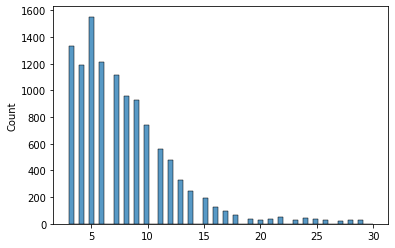

In [33]:
import seaborn as sns
print(min(num_cols), max(num_cols), np.mean(num_cols), np.median(num_cols))
sns.histplot(num_cols)

3

1 29 2.8656768255622125 2.0


<Axes: ylabel='Count'>

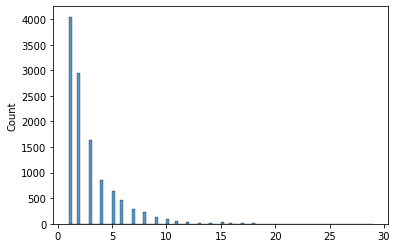

In [34]:
import seaborn as sns
print(min(num_cols_gt), max(num_cols_gt), np.mean(num_cols_gt), np.median(num_cols_gt))
sns.histplot(num_cols_gt)

In [4]:
text = "BERT is a powerful language model."
tokenizer.tokenize(text)

['bert', 'is', 'a', 'powerful', 'language', 'model', '.']

In [43]:
dataset_cls = SotabCVTablewiseDataset
cv = 0
src = None
# train_dataset = dataset_cls(cv=cv,
#                             split="train",
#                             src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1")
# valid_dataset = dataset_cls(cv=cv,
#                             split="valid", src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1")
test_dataset = dataset_cls(# cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            # multicol_only=multicol_only,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "SOTAB")
                            )


标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_test_fully_deduplicated_sotab.csv 加载
start encoder
Processed 1000 entries. Recent dataframe sample:
Processed 2000 entries. Recent dataframe sample:
Processed 3000 entries. Recent dataframe sample:
Processed 4000 entries. Recent dataframe sample:
Processed 5000 entries. Recent dataframe sample:
Processed 6000 entries. Recent dataframe sample:
Processed 7000 entries. Recent dataframe sample:
test 7026


In [45]:
len(test_dataset)

7026

In [4]:
# train_dataloader = DataLoader(train_dataset,
#                                 batch_size=batch_size,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)
# valid_dataloader = DataLoader(valid_dataset,
#                                 batch_size=batch_size,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)
test_dataloader = DataLoader(test_dataset,
                                batch_size=64,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [46]:
dataset_cls = SotabCVTablewiseDataset
cv = 0
src = None
train_dataset = dataset_cls(# cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            # multicol_only=multicol_only,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "SOTAB")
                            )
train_dataloader = DataLoader(train_dataset,
                                batch_size=20,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_train_fully_deduplicated_sotab.csv 加载
start encoder
Processed 1000 entries. Recent dataframe sample:
Processed 2000 entries. Recent dataframe sample:
Processed 3000 entries. Recent dataframe sample:
Processed 4000 entries. Recent dataframe sample:
Processed 5000 entries. Recent dataframe sample:
Processed 6000 entries. Recent dataframe sample:
Processed 7000 entries. Recent dataframe sample:
Processed 8000 entries. Recent dataframe sample:
Processed 9000 entries. Recent dataframe sample:
Processed 10000 entries. Recent dataframe sample:
Processed 11000 entries. Recent dataframe sample:
train 11517


In [19]:
class_freq = torch.zeros(args.num_classes)
for batch in train_dataloader:
    for i in batch["label"][batch["label"]>-1].cpu().tolist():
        class_freq[i] += 1


In [ ]:
class_freq = torch.zeros(args.num_classes)

In [5]:
def extract_cls_tokens(hidden_states, cls_indexes, head=False):
    cls_embeddings = []
    for i, j in cls_indexes:
        sub_sentence_cls_embeddings = hidden_states[i, 0, :] if head else hidden_states[i, j, :]
        cls_embeddings.append(sub_sentence_cls_embeddings)
    cls_embeddings = torch.stack(cls_embeddings)
    return cls_embeddings
#pooled_outputs = extract_cls_tokens(hidden_states, cls_indexes)

In [28]:
batch["label"].cpu().shape

torch.Size([7])

In [30]:
embs.detach().cpu().shape

torch.Size([7, 768])

In [274]:
model.eval()
model = model.to(device)
plm_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(train_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    label = batch["label"].cpu()
    plm_embs_train.append(embs.detach().cpu()[label>-1])
    labels_train.append(label[label>-1])
plm_embs_train = torch.cat(plm_embs_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

NameError: name 'train_dataloader' is not defined

In [32]:
plm_embs_train.shape

torch.Size([3463, 768])

In [15]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
def silhouette_score_per_cluster(embeddings, labels, metric="cosine"):
    sample_silhouette_values = silhouette_samples(embeddings, labels, metric=metric)
    unique_labels = np.unique(labels)
    silhouette_per_cluster = []
    for label in unique_labels:
        cluster_silhouettes = sample_silhouette_values[labels == label]
        silhouette_per_cluster.append(np.mean(cluster_silhouettes))
    return np.array(silhouette_per_cluster).reshape(-1)

In [34]:
plm_embs_train_silhouette_values = silhouette_samples(plm_embs_train, labels_train)

In [35]:
np.mean(plm_embs_train_silhouette_values)

-0.21431549

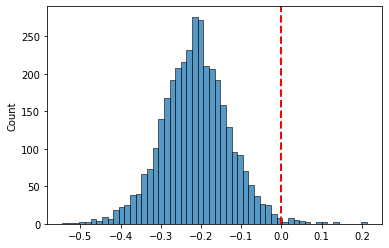

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming plm_embs_train_silhouette_values is your data
sns.histplot(plm_embs_train_silhouette_values)

# Add a red vertical line at x = 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Display the plot
plt.show()

In [22]:
cv

0

In [23]:
dataset_col = GittablesColwiseDataset
train_dataset_col = dataset_col(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            train_ratio=1.0,
                            device=device,
                            small_tag="semi1",
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            max_num_col=1,
                            sampling_method=None,
                            random_seed=0,
                            context_encoding_type=args.context_encoding_type,
                            adaptive_max_length=False                                       
                            )
# dataset_cls(cv=cv,
#                                             split="train",
#                                             tokenizer=tokenizer,
#                                             max_length=max_length,
#                                             gt_only='all' not in task,
#                                             device=device,
#                                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                                             small_tag=args.small_tag,
#                                             max_num_col=args.max_num_col,
#                                             sampling_method=args.sampling_method,
#                                             random_seed=args.random_seed,
#                                             context_encoding_type=args.context_encoding_type,
#                                             adaptive_max_length=args.adaptive_max_length)

semi1_cv_{}.csv 1 64 None v0 False
train 3463


In [24]:
train_dataloader_col = DataLoader(train_dataset_col,
                                batch_size=batch_size,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [25]:
model.eval()
model = model.to(device)
plm_embs_train_col = []
labels_train_col = []
for batch_idx, batch in enumerate(train_dataloader_col):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    plm_embs_train_col.append(embs.detach().cpu())
    labels_train_col.append(batch["label"].cpu())
plm_embs_train_col = torch.cat(plm_embs_train_col, dim=0)
labels_train_col = torch.cat(labels_train_col, dim=0)

In [26]:
plm_embs_train_col.shape

torch.Size([3463, 768])

In [33]:
plm_embs_train.shape

torch.Size([3463, 768])

In [37]:
plm_embs_train_silhouette_values_col = silhouette_samples(plm_embs_train_col, labels_train_col)

In [38]:
np.mean(plm_embs_train_silhouette_values_col)

-0.22704358

In [39]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

In [40]:

base_dirpath = "/data/zhihao/TU/GitTables/semtab_gittables/2022/"
seperator = "semi1"
basename = seperator+"_cv_{}.csv"
df_list = []
filepath = os.path.join(base_dirpath, basename.format(cv))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")



df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [44]:
labels_cluster = []
embeddings_cluster = []
embeddings_cluster_context = []
for i, (index, group_df) in enumerate(df_group_train):
    labeled_columns = group_df[group_df['class_id'] > -1]
    labels_cluster += labeled_columns["class_id"].values.tolist()
    # if len(labeled_columns) > 1:
    #     embeddings_cluster.append(ft_model.get_sentence_vector(" ".join(labeled_columns["data"].values)))
    #     embeddings_cluster_context.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values)))
    #     break
    for text in labeled_columns["data"].values:
        embeddings_cluster.append(st_model.encode(text))
        embeddings_cluster_context.append(st_model.encode(st_model.tokenizer.sep_token.join(group_df["data"].values)))

In [47]:
embeddings_cluster = np.stack(embeddings_cluster, axis=0)

In [49]:
embeddings_cluster_context = np.stack(embeddings_cluster_context, axis=0)

In [53]:
labels_cluster = np.array(labels_cluster)

In [54]:
embeddings_cluster_silhouette_values = silhouette_samples(embeddings_cluster, labels_cluster)
embeddings_cluster_context_silhouette_values = silhouette_samples(embeddings_cluster_context, labels_cluster)

In [55]:
np.mean(embeddings_cluster_silhouette_values)

-0.08592572

In [56]:
np.mean(embeddings_cluster_context_silhouette_values)

-0.15294842

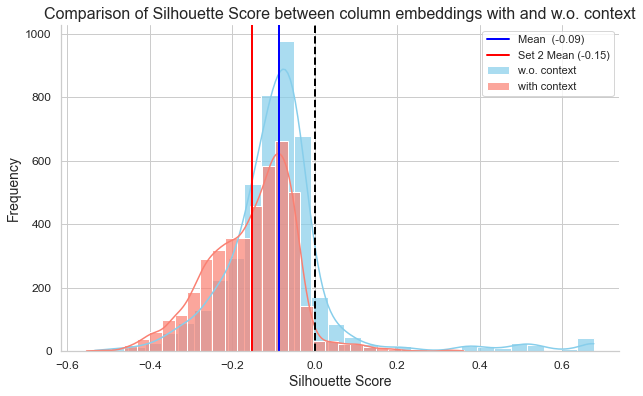

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data: Two sets of values
values_set_1 = embeddings_cluster_silhouette_values  # Replace with your actual data
values_set_2 = embeddings_cluster_context_silhouette_values  # Replace with your second set of values

mean_set_1 = np.mean(values_set_1)
mean_set_2 = np.mean(values_set_2)
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the first set of values
sns.histplot(values_set_1, color='skyblue', kde=True, label='w.o. context', bins=30, alpha=0.7)

# Plot the second set of values
sns.histplot(values_set_2, color='salmon', kde=True, label='with context', bins=30, alpha=0.7)

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.axvline(x=mean_set_1, color='blue', linestyle='-', linewidth=2, label=f'Mean  ({mean_set_1:.2f})')
plt.axvline(x=mean_set_2, color='red', linestyle='-', linewidth=2, label=f'Set 2 Mean ({mean_set_2:.2f})')

# Customize the plot
plt.title('Comparison of Silhouette Score between column embeddings with and w.o. context', fontsize=16)
plt.xlabel('Silhouette Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.show()

In [7]:
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-poolv0-unlabeled8-randTrue-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)
# bert-base-uncased-fromscratch-semi1-poolv0-unlabeled8-randTrue-bs16-ml64-ne50-do0.1_best_f1_micro.pt
# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_macro']['true_list'])
preds = np.array(results['f1_macro']['pred_list'])
class_f1 = np.array(results['f1_macro']['ts_class_f1'])

In [4]:
best_state_dict = torch.load("/data/yongkang/TU/Watchog/outputs/SOTAB/bert-base-uncased-fromscratch-comma-bs16-ml128-ne50-do0.5_fully_deduplicated_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_1394094/1786997412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/yongkang/TU/Watchog/outputs/SOTAB/bert-base-uncased

<All keys matched successfully>

In [12]:
model.eval()
model = model.to(device)
ft_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(train_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    ft_embs_train.append(embs.detach().cpu())
    labels_train.append(batch["label"].cpu())
ft_embs_train = torch.cat(ft_embs_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

In [8]:
test_dataloader = DataLoader(test_dataset,
                                batch_size=64,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_origin = []
logits_test_origin_1 = []
cls_indexes_all_1 = []
for batch_idx, batch in enumerate(test_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    
    # embs = model.bert(batch["data"].T)
    logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
    # embs = extract_cls_tokens(embs[0], cls_indexes)
    # ft_embs_test.append(embs.detach().cpu())
    labels_test_origin.append(batch["label"].cpu())
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
    logits_test_origin_1.append(logits)
    cls_indexes_all_1.append(cls_indexes.detach().cpu())
# ft_embs_test = torch.cat(ft_embs_test, dim=0)

labels_test_origin = torch.cat(labels_test_origin, dim=0)
logits_test_origin_1 = torch.cat(logits_test_origin_1, dim=0)
preds_test_origin_1 = torch.argmax(logits_test_origin_1, dim=1)

In [9]:
torch.cuda.empty_cache()

In [321]:
is_equal = []
for i in range(len(logits_test_origin_16)):
    is_equal.append(torch.equal(logits_test_origin_16[i], logits_test_origin_1[i]))

In [320]:
True in is_equal

True

In [314]:
logits_test_origin_1.shape

torch.Size([1085, 101])

In [10]:
ts_pred_list_origin = logits_test_origin_1.argmax(
                            1).cpu().detach().numpy().tolist()
from sklearn.metrics import confusion_matrix, f1_score
ts_micro_f1 = f1_score(labels_test_origin.reshape(-1).numpy().tolist(),
                    ts_pred_list_origin,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_origin.reshape(-1).numpy().tolist(),
                    ts_pred_list_origin,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.7269, ts_macro_f1=0.6960


In [11]:
import torch.nn.functional as F
ood_score = F.softmax(logits_test_origin_1, dim=1).max(1).values
ood_labels = torch.tensor(preds_test_origin_1 == labels_test_origin).float()

/tmp/ipykernel_945138/1939110723.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test_origin_1 == labels_test_origin).float()


In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ood_labels, ood_score)

0.81275285856383

In [39]:
def compute_entropy(probs):
    # Adding a small value (1e-9) to avoid log(0)
    if probs.dim() == 1:
        return -torch.sum(probs * torch.log(probs))
    else:
        return -torch.sum(probs * torch.log(probs), dim=1)

In [34]:
import torch.nn.functional as F
ood_score = compute_entropy(F.softmax(logits_test_origin_1, dim=1))
ood_labels = torch.tensor(preds_test_origin_1 != labels_test_origin).float()
from sklearn.metrics import roc_auc_score

roc_auc_score(ood_labels, ood_score)

/tmp/ipykernel_4054970/4129975340.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test_origin_1 != labels_test_origin).float()


0.7723833738213859

<Axes: ylabel='Count'>

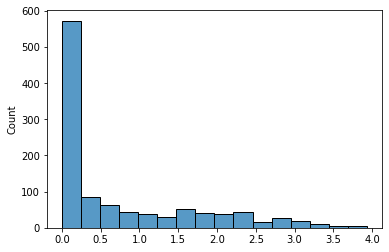

In [26]:
import seaborn as sns
sns.histplot(ood_score)

<Axes: ylabel='Count'>

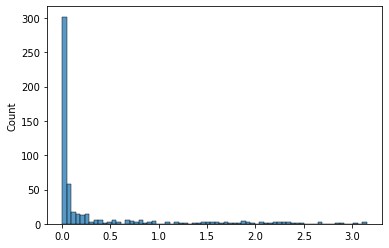

In [27]:
sns.histplot(ood_score[ood_labels==0])

<Axes: ylabel='Count'>

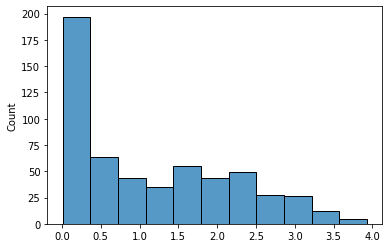

In [28]:
sns.histplot(ood_score[ood_labels==1])

In [30]:
threshold = 0.25
(ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold)

tensor(0.7680)

In [32]:
threshold = 0.1
(ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold)

tensor(0.7262)

In [108]:
(ood_score[ood_labels==0] < 0.99).sum()/len(ood_score[ood_labels==0])

tensor(0.8188)

In [26]:
(ood_score[ood_labels==1] < 0.99).sum()/len(ood_score[ood_labels==1])

tensor(0.3378)

In [27]:
(ood_score[ood_labels==1] < 0.99).sum()/len(ood_score[ood_labels==1])

tensor(0.3378)

In [ ]:
for test_dataloader

In [31]:
from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer
from typing import List
from functools import reduce
import operator
from sklearn.preprocessing import LabelEncoder
class SOTABTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            # cv: int,
            split: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            # multicol_only: bool = False,
            train_ratio: float = 1.0,
            device: torch.device = None,
            base_dirpath: str = "/data/yongkang/TU/SOTAB",
            small_tag: str = "",
            label_encoder: LabelEncoder = None,
            max_unlabeled=8,
            random_sample=False, # TODO
            gt_only=True,
            ):
        # ?
        if device is None:
            device = torch.device('cpu')

        assert split in ["train", "valid", "test"]
        if split == "train":
            gt_df = pd.read_csv(os.path.join(base_dirpath, "CTA_training_small_gt.csv"))
            data_folder = "Train"
        elif split == "valid":
            gt_df = pd.read_csv(os.path.join(base_dirpath, "CTA_validation_gt.csv"))
            data_folder = "Validation"
        else:  # test
            gt_df = pd.read_csv(os.path.join(base_dirpath, "CTA_test_gt.csv"))
            data_folder = "Test"

        # 初始化或加载 LabelEncoder
        if label_encoder is None:
            label_encoder = LabelEncoder()
            label_encoder.fit(gt_df['label'])
        self.label_encoder = label_encoder

        # gt_set = set(zip(gt_df["table_name"], gt_df["column_index"]))

        table_files = [f for f in os.listdir(os.path.join(base_dirpath, data_folder)) if f in gt_df['table_name'].values]

        mapping_file_path = os.path.join(base_dirpath, "label_mapping.txt")
        df_csv_path = os.path.join(base_dirpath, f"comma_{split}_fully_deduplicated_sotab.csv")

        # 检查是否存在之前保存的标签映射关系
        if os.path.exists(mapping_file_path):
            # 如果存在，直接从文件中读取映射
            with open(mapping_file_path, 'r') as f:
                label_mapping = json.load(f)
            next_label_id = max(label_mapping.values()) + 1
            print(f"标签映射关系从 {mapping_file_path} 读取成功")
        else:
            raise FileNotFoundError(f"{mapping_file_path} 文件不存在，请确认文件路径")

        # 检查 CSV 文件是否存在
        if os.path.exists(df_csv_path):
            # 直接从 CSV 文件中读取数据
            df = pd.read_csv(df_csv_path)
            print(f"数据已从 {df_csv_path} 加载")
        else:
            raise FileNotFoundError(f"{df_csv_path} 文件不存在，请确认文件路径")
        
        if gt_only:
            df = df[df["label"] > -1]

        data_list = []

        df['label'] = df['label'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['label'] == -1)].index, inplace=True)
        df['column_index'] = df['column_index'].astype(int)
        df['data'] = df['data'].astype(str)

        print("start encoder")
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            # if split == "train" and ((i >= num_train) or (i >= valid_index)):
            #     break
            # if split == "valid" and i < valid_index:
            #     continue

            labeled_columns = group_df[group_df['label'] > -1]
            unlabeled_columns = group_df[group_df['label'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns))
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            group_df = pd.concat([group_df[group_df['label'] > -1], unlabeled_columns]) # TODO
            group_df.sort_values(by=['column_index'], inplace=True)

            num_labels = len(list(group_df["label"].values))
            if max_length <= 128:
                cur_maxlen = min(max_length, 512 // num_labels - 1)
            else:
                cur_maxlen = max(1, max_length // num_labels - 1)

            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["label"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                new_token_ids_list = []
                for col_j in range(len(token_ids_list)):
                    if len(set(target_col_mask)) == max_unlabeled-1 and 0 not in target_col_mask and col_j != col_i:
                        # skip the rest of the columns until the target one
                        continue
                    
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                    new_token_ids_list.append(token_ids_list[col_j])
                    if len(set(target_col_mask)) == max_unlabeled and 0 in target_col_mask:
                        break
                new_token_ids_list = torch.LongTensor(reduce(operator.add,
                                                new_token_ids_list)).to(device)
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["label"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), new_token_ids_list, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [32]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [7]:
src = None
test_dataset_iter = SOTABTablewiseIterateDataset(# cv=cv,
                                        split="test",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        # multicol_only=multicol_only,
                                        device=device,
                                        gt_only=False,
                                        base_dirpath=os.path.join(args.data_path, "SOTAB")
                                        )
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_test_fully_deduplicated_sotab.csv 加载
start encoder
test 15040


In [8]:
src = None
valid_dataset_iter = SOTABTablewiseIterateDataset(# cv=cv,
                                        split="valid",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        # multicol_only=multicol_only,
                                        device=device,
                                        gt_only=False,
                                        base_dirpath=os.path.join(args.data_path, "SOTAB")
                                        )
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_iter = DataLoader(valid_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_valid_fully_deduplicated_sotab.csv 加载
start encoder
valid 16840


In [33]:
max_num_cols = 8
train_dataset_iter = SOTABTablewiseIterateDataset(
                            split="train", 
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only=False,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "SOTAB"),
                            max_unlabeled=max_num_cols)
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_train_fully_deduplicated_sotab.csv 加载
start encoder
train 33004


In [17]:
num_cols_train = []
for batch_idx, batch in enumerate(train_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    num_cols_train.append(len(init_permutation_i))


NameError: name 'sns' is not defined

<Axes: ylabel='Count'>

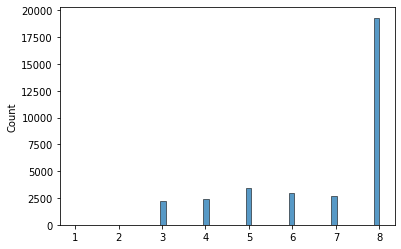

In [19]:
import seaborn as sns
sns.histplot(num_cols_train)

In [10]:
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
 
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.8781, ts_macro_f1=0.8657
ts_micro_f1=0.8781, ts_macro_f1=0.8657
ts_micro_f1=0.0000, ts_macro_f1=nan


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
wrong_idx = []
for batch_idx, batch in enumerate(train_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    if not batch["data"].T.shape == target_col_mask.shape:
        wrong_idx.append(batch_idx)

In [27]:
len(wrong_idx)

4921

True

torch.Size([1, 420])

In [34]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
train_data = defaultdict(list)
train_logits = defaultdict(list)
train_cls_indexes = defaultdict(list)
train_target_col_mask = defaultdict(list)
train_embs = defaultdict(list)
train_col_num = defaultdict(list)
train_label = defaultdict(list)
train_class = defaultdict(list)
train_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(train_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            train_data[batch_idx].append(batch["data"].T.cpu())
            train_logits[batch_idx].append(logits.detach().cpu())
            train_cls_indexes[batch_idx].append(batch["cls_indexes"].cpu().item())
            train_embs[batch_idx].append(embs.cpu())
            train_col_num[batch_idx].append(len(init_permutation_i))
            train_label[batch_idx].append(torch.tensor(predict_init == label_i).long()) # indicate whether the permutation is correct or not
            train_class[batch_idx].append(label_i)


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    if predict_temp == label_i and r < max(len(init_permutation_i)-2, len(init_permutation_i)//2):
                        continue
                    
                    
                    train_data[batch_idx].append(new_batch_data.cpu())
                    train_logits[batch_idx].append(logits_temp.detach().cpu())
                    train_cls_indexes[batch_idx].append(cls_indexes_value)
                    train_embs[batch_idx].append(embs_temp.cpu())
                    train_col_num[batch_idx].append(len(x))
                    train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

*********************Threshold: 1.5****************************


/tmp/ipykernel_1394094/2362306214.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1394094/2362306214.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [49]:
total_samples = 0
for batch_idx, batch in enumerate(train_dataloader_iter):
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)

    assert -1 not in col_idx_set
    for r in range(len(init_permutation_i), 0, -1): # not 
        for x in itertools.combinations(init_permutation_i, r):
            if 0 not in x:
                continue
            total_samples += 1
            

In [50]:
total_samples

2821583

In [41]:
len(train_dataloader_iter)

33004

In [48]:
len(valid_dataloader_iter)

16840

In [47]:
len(train_dataset)

11517

In [36]:
import os
# SOTAB, col num from 8 to 1, all negs, half pos
os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data.pth")

In [37]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

955609


tensor(0.7282)

In [35]:
args.task

'SOTAB'

In [38]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
# {args.task}_veri_data: min length: max(len(init_permutation_i)//2, len(init_permutation_i)-3)
# {args.task}_veri_data_1: min length: for those without correct permutation, 
veri_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")
veri_data = veri_results["data"]
veri_label = veri_results["label"]
veri_logits = veri_results["logits"]
veri_cls_indexes = veri_results["cls_indexes"]
veri_embs = veri_results["embs"]
veri_target_embs = veri_results["target_embs"]
veri_col_num = veri_results["col_num"]

/tmp/ipykernel_1394094/1574061451.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  veri_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data

In [39]:
num_train = len(train_data)
for i in veri_data:
    train_data[num_train+i] = veri_data[i]
    train_label[num_train+i] = veri_label[i]
    train_logits[num_train+i] = veri_logits[i]
    train_cls_indexes[num_train+i] = veri_cls_indexes[i]
    train_embs[num_train+i] = veri_embs[i]
    train_target_embs[num_train+i] = veri_target_embs[i]
    train_col_num[num_train+i] = veri_col_num[i]

In [40]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

2385537


tensor(0.7962)

In [14]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)
test_target_embs = defaultdict(list)
test_drop_idx = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            test_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 1, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    if len(x) != len(init_permutation_i):
                        drop_idx = (set(init_permutation_i)-set(x)).pop()
                    else:
                        drop_idx = -1
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    test_data[batch_idx].append(new_batch_data.cpu())
                    test_logits[batch_idx].append(logits_temp.detach().cpu())
                    test_cls_indexes[batch_idx].append(cls_indexes_value)
                    test_embs[batch_idx].append(embs_temp.cpu())
                    test_col_num[batch_idx].append(len(x))
                    test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    test_class[batch_idx].append(label_i)
                    test_drop_idx[batch_idx].append(drop_idx)

*********************Threshold: 1.5****************************


/tmp/ipykernel_1385896/3553952053.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1385896/3553952053.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [ ]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.pth")

In [27]:
import torch.nn.functional as F
ood_score = F.softmax(logits_test, dim=1).max(1).values
ood_labels = torch.tensor(preds == labels).float()

In [33]:
(ood_score[ood_labels==0] < 0.99).sum()/sum(ood_labels==0)

tensor(0.8592)

In [35]:
threshold = 0.5
(ood_score[ood_labels==0] < threshold).sum()/sum(ood_score<threshold)

tensor(0.7678)

In [10]:
# Single column results
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, 0]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T[:, target_col_mask[0]==0], cls_indexes=cls_indexes,)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)

from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5284, ts_macro_f1=0.4741
ts_micro_f1=0.5284, ts_macro_f1=0.4741
ts_micro_f1=0.0000, ts_macro_f1=nan


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
# Cheat drop one-column
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
logits_init = []
logits_correct = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits_init.append(logits.detach().cpu())
                logits_correct.append(logits_temp.detach().cpu())
                corrected += 1
                break

In [ ]:
# Cheat brute force permutation
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
logits_init = []
logits_correct = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits_init.append(logits.detach().cpu())
                logits_correct.append(logits_temp.detach().cpu())
                corrected += 1
                break

In [48]:
len(logits_init)

34

In [49]:
total_mistakes

314

In [50]:
logits_init = torch.stack(logits_init, dim=0)
logits_correct = torch.stack(logits_correct, dim=0)

In [52]:
ood_score_init = F.softmax(logits_init, dim=1).max(1).values
ood_score_correct = F.softmax(logits_correct, dim=1).max(1).values

In [54]:
((ood_score_correct - ood_score_init)>0).sum()

tensor(23)

In [21]:
print(corrected, total_mistakes, corrected/total_mistakes)

34 314 0.10828025477707007


In [37]:
def get_permutation(x):
    new = []
    for k in x.tolist()[0]:
        if k not in new:
            new.append(k)
    return new

In [48]:
# Cheat brute force perumate

import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for context_length in [3, 4, 6, 8, 12, 16]:
    print(f"*********************Context length: {context_length}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    threshold = 0.8
    corrected = 0
    total_mistakes = 0
    init_permutation = defaultdict(list)
    corrected_permutation = defaultdict(list)
    init_logits = defaultdict(list)
    corrected_logits = defaultdict(list)
    MSP_permutation = defaultdict(list)
    MSP_logits = defaultdict(list)
    MSP_corrected = 0
    Entropy_permutation = defaultdict(list)
    Entropy_logits = defaultdict(list)
    Entropy_corrected = 0
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        logits_init = logits.clone()
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
            total_mistakes += 1
            col_idx_set = target_col_mask.unique().tolist()
            successs = False
            init_permutation[batch_idx].append(get_permutation(target_col_mask))
            init_logits[batch_idx].append(logits_init.detach().cpu())        
            max_msp = F.softmax(logits_init).detach().cpu().max().item()
            msp_logits = logits_init.clone().detach().cpu()
            msp_perm = get_permutation(target_col_mask)[0]
            min_entropy = compute_entropy(F.softmax(logits_init)).item()
            entropy_logits = logits_init.clone().detach().cpu()
            entropy_perm = get_permutation(target_col_mask)[0]
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set) + 1, context_length+1)):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        if x[0] != 0:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])

                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        if logits_temp.argmax().item() == batch["label"].item():
                            logits = logits_temp.clone()
                            successs = True
                            corrected_permutation[batch_idx].append(x)
                            corrected_logits[batch_idx].append(logits_temp.clone().detach().cpu())
                        
                        temp_msp = F.softmax(logits_temp).max().item()
                        if max_msp < temp_msp:
                            max_msp = temp_msp
                            msp_logits = logits_temp.clone().detach().cpu()
                            msp_perm = x
                        # temp_entropy = compute_entropy(F.softmax(logits_temp)).item()
                        # if min_entropy > temp_entropy:
                        #     min_entropy = temp_entropy
                        #     entropy_logits = logits_temp.clone().detach().cpu()
                        #     entropy_perm = x
            MSP_logits[batch_idx].append(msp_logits)
            MSP_permutation[batch_idx].append(msp_perm)
            if msp_logits.argmax().item() == batch["label"].item():
                MSP_corrected += 1
                # print(f"MSP correct {batch_idx}")
            # Entropy_logits[batch_idx].append(entropy_logits)
            # Entropy_permutation[batch_idx].append(entropy_perm)
            # if entropy_logits.argmax().item() == batch["label"].item():
            #     Entropy_corrected += 1
            #     # print(f"Entropy correct {batch_idx}")
            if successs:
                corrected += 1
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Context length: 3****************************


/tmp/ipykernel_945138/4260784345.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  max_msp = F.softmax(logits_init).detach().cpu().max().item()
/tmp/ipykernel_945138/4260784345.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  min_entropy = compute_entropy(F.softmax(logits_init)).item()
/tmp/ipykernel_945138/4260784345.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_msp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.9592, ts_macro_f1=0.9528
ts_micro_f1=0.9592, ts_macro_f1=0.9528
ts_micro_f1=0.0000, ts_macro_f1=nan
*********************Context length: 4****************************


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_945138/4260784345.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  max_msp = F.softmax(logits_init).detach().cpu().max().item()
/tmp/ipykernel_945138/4260784345.py:45: UserWarning: Implicit dimension choice for softmax 

ts_micro_f1=0.9726, ts_macro_f1=0.9668
ts_micro_f1=0.9726, ts_macro_f1=0.9668
ts_micro_f1=0.0000, ts_macro_f1=nan
*********************Context length: 6****************************


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_945138/4260784345.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  max_msp = F.softmax(logits_init).detach().cpu().max().item()
/tmp/ipykernel_945138/4260784345.py:45: UserWarning: Implicit dimension choice for softmax 

KeyboardInterrupt: 

In [ ]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
context_length = 2
for threshold in [0.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            
            cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
            logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)  
            logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
            ood_score_target = logits_temp.max().item()
            ood_score_target_list.append(ood_score_target)
            uncertain_target_mask.append(ood_score_target < threshold)
            predict_target = logits_temp.argmax().item()
            correct_target_mask.append(predict_target == batch["label"].item())
            

            init_target_mask.append(predict_target == predict_init)
            
            correct_permutation = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, context_length+1):
                    # if 0 not in subset:
                    #     continue
                    for x in itertools.permutations(subset):
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                            debias_class.append(predict_temp)
                            continue
                        # print(x, msp_temp, predict_temp)
                        if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_msp_mask.append(msp_predict == batch["label"].item())

In [ ]:

# brute force perumate, find uncertain init prediction
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []


alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            num_cols.append(batch["target_col_mask"].max().item())
            ood_score_init = F.softmax(logits.detach()).max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            
            cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
            logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)    
            ood_score_target = F.softmax(logits_temp.detach()).max().item()
            ood_score_target_list.append(ood_score_target)
            uncertain_target_mask.append(ood_score_target < threshold)
            predict_target = logits_temp.argmax().item()
            correct_target_mask.append(predict_target == batch["label"].item())
            
            init_target_mask.append(predict_target == predict_init)
            
            correct_permutation = False
            ood_score_max = 0
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp =F.softmax(logits_temp.detach()).max().item()
                        predict_temp = logits_temp.argmax().item()
                        if ood_score_temp > ood_score_max:
                            ood_score_max = ood_score_temp 
                            predict_ood = logits_temp.argmax().item()
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
            correct_permutation_mask.append(correct_permutation)
            correct_msp_mask.append(predict_ood == batch["label"].item())

In [23]:
def reweight_logits(logits, class_weights):
    # Step 1: Apply exp(logits)
    exp_logits = torch.exp(logits)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_exp = exp_logits * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_exp / reweighted_exp.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [8]:
class_freq = torch.load("/data/yongkang/TU/SOTAB/class_freq.pt")

/tmp/ipykernel_2586507/3498784723.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_freq = torch.load("/data/yongkang/TU/SOTAB/class_freq.pt")


In [11]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
context_length = 2
for threshold in [0.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            # logits = reweight_logits(logits.detach().cpu(), class_weights)
            logits = F.softmax(logits.detach().cpu())
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            
            cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
            logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)  
            # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
            logits_temp = F.softmax(logits_temp.detach().cpu())
            ood_score_target = logits_temp.max().item()
            ood_score_target_list.append(ood_score_target)
            uncertain_target_mask.append(ood_score_target < threshold)
            predict_target = logits_temp.argmax().item()
            correct_target_mask.append(predict_target == batch["label"].item())
            

            init_target_mask.append(predict_target == predict_init)
            
            correct_permutation = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set) + 1, context_length+1)):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        logits_temp = F.softmax(logits_temp.detach().cpu())
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                            debias_class.append(predict_temp)
                            continue
                        # print(x, msp_temp, predict_temp)
                        if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_msp_mask.append(msp_predict == batch["label"].item())

*********************Threshold: 0.5****************************


/tmp/ipykernel_2586507/1723896548.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits.detach().cpu())
/tmp/ipykernel_2586507/1723896548.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp.detach().cpu())
/tmp/ipykernel_2586507/1723896548.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp.detach().cpu())


In [12]:

idx_list = torch.tensor(idx_list)
uncertain_init_mask = torch.tensor(uncertain_init_mask)
uncertain_target_mask = torch.tensor(uncertain_target_mask)
correct_init_mask = torch.tensor(correct_init_mask)
correct_target_mask = torch.tensor(correct_target_mask)
correct_permutation_mask = torch.tensor(correct_permutation_mask)
correct_msp_mask = torch.tensor(correct_msp_mask)
init_target_mask = torch.tensor(init_target_mask)
ood_score_init_list = torch.tensor(ood_score_init_list)
ood_score_target_list = torch.tensor(ood_score_target_list)
ood_score_final_list = torch.tensor(ood_score_final_list)
print(len(idx_list), len(uncertain_init_mask), len(uncertain_target_mask), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask), len(correct_msp_mask))

# torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "init_target_mask": init_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/SOTAB_brute_force_permutation_context@{context_length}.pth")

15040 15040 15040 15040 15040 15040 15040 15040


In [32]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
context_length = 3
for threshold in [0.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            
            cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
            logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)  
            logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
            ood_score_target = logits_temp.max().item()
            ood_score_target_list.append(ood_score_target)
            uncertain_target_mask.append(ood_score_target < threshold)
            predict_target = logits_temp.argmax().item()
            correct_target_mask.append(predict_target == batch["label"].item())
            

            init_target_mask.append(predict_target == predict_init)
            
            correct_permutation = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set) + 1, context_length+1)):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                            debias_class.append(predict_temp)
                            continue
                        # print(x, msp_temp, predict_temp)
                        if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_msp_mask.append(msp_predict == batch["label"].item())

*********************Threshold: 0.5****************************


In [65]:
class_freq.max()/class_freq.min()

tensor(87.5263)

In [34]:

idx_list = torch.tensor(idx_list)
uncertain_init_mask = torch.tensor(uncertain_init_mask)
uncertain_target_mask = torch.tensor(uncertain_target_mask)
correct_init_mask = torch.tensor(correct_init_mask)
correct_target_mask = torch.tensor(correct_target_mask)
correct_permutation_mask = torch.tensor(correct_permutation_mask)
correct_msp_mask = torch.tensor(correct_msp_mask)
init_target_mask = torch.tensor(init_target_mask)
ood_score_init_list = torch.tensor(ood_score_init_list)
ood_score_target_list = torch.tensor(ood_score_target_list)
ood_score_final_list = torch.tensor(ood_score_final_list)
print(len(idx_list), len(uncertain_init_mask), len(uncertain_target_mask), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask), len(correct_msp_mask))

# torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "init_target_mask": init_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/SOTAB_brute_force_permutation_weighted_context@{context_length}.pth")

15040 15040 15040 15040 15040 15040 15040 15040


/tmp/ipykernel_1991562/1785266914.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx_list = torch.tensor(idx_list)
/tmp/ipykernel_1991562/1785266914.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncertain_init_mask = torch.tensor(uncertain_init_mask)
/tmp/ipykernel_1991562/1785266914.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncertain_target_mask = torch.tensor(uncertain_target_mask)
/tmp/ipykernel_1991562/1785266914.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

In [54]:
# weighted, only uncertain init
for threshold in [0.5, 0.8, 0.9]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.5****************************
Init
13175 14821 0.8889413669792862
62 219 0.2831050228310502
MSP
11161 14821 0.753053100330612
45 219 0.2054794520547945
MSP & Init
10941
13395 14821 0.9037851696916538
82 219 0.3744292237442922
Permutation
14253 14821 0.9616760002698873
171 219 0.7808219178082192
*********************Threshold: 0.8****************************
Init
12908 14189 0.9097187962506167
329 851 0.38660399529964745
MSP
10975 14189 0.7734865036295722
231 851 0.27144535840188017
MSP & Init
10833
13050 14189 0.9197265487349355
427 851 0.5017626321974148
Permutation
13716 14189 0.9666643174289943
708 851 0.8319623971797885
*********************Threshold: 0.9****************************
Init
12734 13845 0.9197544239797761
503 1195 0.42092050209205023
MSP
10871 13845 0.7851932105453232
335 1195 0.2803347280334728
MSP & Init
10757
12848 13845 0.9279884434814012
629 1195 0.5263598326359833
Permutation
13432 13845 0.9701697363669195
992 1195 0.830125523012

In [13]:
# weighted, only uncertain init
for threshold in [0.5, 0.8, 0.9]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.5****************************
Init
13164 14871 0.885212830340932
42 169 0.2485207100591716
MSP
10647 14871 0.7159572321968933
27 169 0.15976331360946747
MSP & Init
10443
13368 14871 0.898930804922332
58 169 0.3431952662721893
Permutation
13296 14871 0.8940891668347791
84 169 0.4970414201183432
*********************Threshold: 0.8****************************
Init
12923 14278 0.9050987533267965
283 762 0.37139107611548555
MSP
10496 14278 0.7351169631601064
178 762 0.2335958005249344
MSP & Init
10361
13058 14278 0.9145538590839053
368 762 0.48293963254593175
Permutation
12928 14278 0.9054489424289116
452 762 0.5931758530183727
*********************Threshold: 0.9****************************
Init
12731 13900 0.9158992805755396
475 1140 0.4166666666666667
MSP
10408 13900 0.7487769784172662
266 1140 0.23333333333333334
MSP & Init
10304
12835 13900 0.9233812949640288
591 1140 0.5184210526315789
Permutation
12681 13900 0.9123021582733813
699 1140 0.6131578947368

In [41]:
target_id_list_msp = idx_list[~condition_mask&correct_msp_mask&~correct_init_mask]
print(len(target_id_list_msp))

126


In [43]:
target_id_list_init = idx_list[~condition_mask&correct_init_mask&~correct_msp_mask]
print(len(target_id_list_init))

294


In [37]:
# weighted, only uncertain init

for threshold in [0.5, 0.8, 0.9, 0.99]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.5****************************
Init
7457 7941 0.9390504974184611
5780 7099 0.8141991829835188
MSP
7386 7941 0.9301095579901776
3820 7099 0.5381039583039865
MSP & Init
7368
7475 7941 0.9413172144566175
6002 7099 0.8454711931257923
Permutation
7740 7941 0.9746883264072534
6684 7099 0.9415410621214255
*********************Threshold: 0.8****************************
Init
6701 7091 0.9450007051191651
6536 7949 0.8222417914203044
MSP
6654 7091 0.9383725849668594
4552 7949 0.5726506478802366
MSP & Init
6648
6707 7091 0.9458468481173319
6770 7949 0.8516794565354132
Permutation
6922 7091 0.9761669722183048
7502 7949 0.9437665115108819
*********************Threshold: 0.9****************************
Init
6209 6547 0.9483733007484344
7028 8493 0.8275050041210409
MSP
6170 6547 0.9424163739117153
5036 8493 0.5929589073354528
MSP & Init
6167
6212 6547 0.9488315258897205
7265 8493 0.8554103379253503
Permutation
6392 6547 0.9763250343668856
8032 8493 0.945720004709761
**

In [30]:
# weighted, only uncertain init

for threshold in [0.99, 0.999]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.99****************************
Init
11984 12610 0.9503568596352101
1253 2430 0.5156378600823045
MSP
10066 12610 0.7982553528945282
709 2430 0.2917695473251029
MSP & Init
10019
12031 12610 0.9540840602696273
Permutation
11864 12610 0.9408406026962728
1569 2430 0.645679012345679
*********************Threshold: 0.999****************************
Init
8374 8533 0.9813664596273292
4863 6507 0.7473490087597972
MSP
7629 8533 0.8940583616547522
3146 6507 0.483479329952359
MSP & Init
7625
8378 8533 0.9818352279385913
Permutation
8317 8533 0.9746865111918435
5116 6507 0.7862302136161057


In [44]:
target_id_list_msp

tensor([   62,   111,   157,   178,   520,   544,   676,   681,   740,   776,
          790,   874,   945,  1099,  1154,  1185,  1237,  1281,  1309,  1360,
         1378,  2244,  2270,  2395,  2416,  2577,  2781,  2906,  2916,  3282,
         3631,  3655,  3674,  3706,  3783,  3817,  4070,  4161,  4269,  4361,
         4424,  4555,  4608,  4698,  4739,  4900,  4974,  4998,  5584,  5617,
         5795,  5937,  6017,  6184,  6222,  6493,  6885,  7166,  7243,  7313,
         7353,  7451,  8032,  8220,  8280,  8542,  8598,  8698,  8832,  8972,
         9087,  9286,  9692,  9743,  9772, 10176, 10196, 10327, 10335, 10541,
        10669, 10688, 10697, 10698, 10703, 10727, 10772, 10829, 10892, 10997,
        11336, 11374, 11418, 11431, 11575, 11618, 11690, 11759, 11815, 11866,
        11965, 11970, 12038, 12039, 12246, 12267, 12446, 12458, 12500, 12666,
        12770, 12847, 13372, 13436, 13491, 13534, 13623, 13982, 14235, 14249,
        14322, 14406, 14732, 14764, 14901, 14917])

In [62]:
target_id_list_init

tensor([   36,   103,   154,   198,   250,   291,   306,   318,   339,   372,
          411,   416,   521,   539,   558,   616,   628,   650,   659,   703,
          812,   824,   947,  1113,  1126,  1297,  1322,  1358,  1439,  1479,
         1736,  1908,  2010,  2040,  2147,  2176,  2215,  2276,  2291,  2327,
         2332,  2477,  2507,  2509,  2620,  2831,  2936,  3092,  3098,  3119,
         3155,  3191,  3203,  3283,  3357,  3391,  3499,  3549,  3563,  3581,
         3614,  3645,  3656,  3703,  3716,  3760,  3803,  3900,  3906,  3913,
         3918,  3977,  3981,  3994,  4045,  4054,  4078,  4121,  4173,  4188,
         4202,  4206,  4216,  4252,  4260,  4319,  4358,  4379,  4380,  4425,
         4458,  4463,  4470,  4474,  4520,  4523,  4528,  4539,  4597,  4622,
         4641,  4647,  4680,  4685,  4720,  4733,  4768,  4771,  4859,  4874,
         5007,  5034,  5075,  5097,  5116,  5268,  5477,  5496,  5507,  5657,
         5680,  5941,  5946,  5950,  5958,  6228,  6408,  6484, 

In [46]:
def get_permutation(x):
    new = []
    for k in x.tolist()[0]:
        if k not in new:
            new.append(k)
    return new

In [64]:
# use target as head, the MSP context
import itertools
  
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataloader_iter):
    if batch_idx == 103:
        break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T
logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
logits = reweight_logits(logits, class_weights)
logits_init = logits.clone()
num_cols.append(batch["target_col_mask"].max().item())
# if batch_idx == 355:


# print("****weighted****************")
col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = logits_init.max().item()
print(batch["label"].item())
print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, min(len(col_idx_set) + 1, context_length+1)):
    for subset in itertools.combinations(col_idx_set, r):
        # if 0 not in subset:
        #     continue
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            if 0 not in x:
                cls_indexes_value = 0
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            # print("****origin****************")
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()
            # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            # print("****weighted****************")
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max().item()
            predict_temp = logits_temp.argmax().item()
            print(x, msp_temp, predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

22
[1, 2, 3, 0, 4, 5] 0.8812775015830994 22
********************************************************
(0,) 0.6231377720832825 22
(1,) 0.9957733154296875 70
(2,) 0.5916683077812195 15
(3,) 0.9956215620040894 36
(4,) 0.24058352410793304 52
(5,) 0.8036993145942688 21
(0, 1) 0.623483419418335 21
(1, 0) 0.7788912653923035 21
(0, 2) 0.8990749716758728 21
(2, 0) 0.8319035172462463 21
(0, 3) 0.7897941470146179 22
(3, 0) 0.5998058319091797 22
(0, 4) 0.5257799029350281 21
(4, 0) 0.4978789985179901 22
(0, 5) 0.8483963012695312 22
(5, 0) 0.8151366710662842 21
(1, 2) 0.9215726256370544 70
(2, 1) 0.7245780825614929 15
(1, 3) 0.9854430556297302 10
(3, 1) 0.9996833801269531 36
(1, 4) 0.9965258836746216 70
(4, 1) 0.7776814103126526 23
(1, 5) 0.9462572336196899 25
(5, 1) 0.9986319541931152 21
(2, 3) 0.525371789932251 11
(3, 2) 0.9990768432617188 36
(2, 4) 0.9957641959190369 15
(4, 2) 0.3540210723876953 90
(2, 5) 0.9965428709983826 15
(5, 2) 0.9775940179824829 21
(3, 4) 0.9981549978256226 36
(4, 3) 0.9545

In [60]:
for threshold in [0.9]:
    # uncertain_init_mask = ood_score_init_list < threshold
    # uncertain_target_mask = ood_score_target_list < threshold
    # condition_mask = (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))
    print(f"*********************Threshold: {threshold}****************************")
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    for msp_threshold in [0.8, 0.9, 0.99, 0.999]:
        print(f"*********************MSP Threshold: {msp_threshold}****************************")
        msp_uncertain_mask = ood_score_final_list < msp_threshold
        sub_condition = ~condition_mask&correct_msp_mask
        # msp prediction
        print((sub_condition&msp_uncertain_mask).sum().item(), 
            (sub_condition).sum().item(), 
            (sub_condition&msp_uncertain_mask).sum().item()/(sub_condition).sum().item())
        print((sub_condition&~msp_uncertain_mask).sum().item(), 
            (sub_condition).sum().item(), 
            (sub_condition&~msp_uncertain_mask).sum().item()/(sub_condition).sum().item())
        
        print((~condition_mask&~msp_uncertain_mask&correct_msp_mask).sum().item(), 
            (~condition_mask&~msp_uncertain_mask).sum().item(), 
            (~condition_mask&~msp_uncertain_mask&correct_msp_mask).sum().item()/(~condition_mask&~msp_uncertain_mask).sum().item())
        
        print((~condition_mask&msp_uncertain_mask&correct_msp_mask).sum().item(), 
            (~condition_mask&msp_uncertain_mask).sum().item(), 
            (~condition_mask&msp_uncertain_mask&correct_msp_mask).sum().item()/(~condition_mask&msp_uncertain_mask).sum().item())
        
        

*********************Threshold: 0.9****************************
MSP
10871 13845 0.7851932105453232
335 1195 0.2803347280334728
*********************MSP Threshold: 0.8****************************
0 335 0.0
335 335 1.0
335 1193 0.2808046940486169
0 2 0.0
*********************MSP Threshold: 0.9****************************
4 335 0.011940298507462687
331 335 0.9880597014925373
331 1145 0.28908296943231443
4 50 0.08
*********************MSP Threshold: 0.99****************************
33 335 0.09850746268656717
302 335 0.9014925373134328
302 1029 0.293488824101069
33 166 0.19879518072289157
*********************MSP Threshold: 0.999****************************
158 335 0.4716417910447761
177 335 0.5283582089552239
177 595 0.29747899159663865
158 600 0.2633333333333333
